## Установка зависимостей

In [1]:
%pip install pandas matplotlib seaborn openpyxl faker spicy psycopg2 sqlalchemy pylint

Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек

In [2]:
from datetime import datetime, timedelta
from faker import Faker 
import pandas as pd
import psycopg2 as psql
import csv
from scipy import stats
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import random
import openpyxl
from scipy.stats import mode
import seaborn as sns

### Настройка окружения

In [3]:
fake = Faker()
sns.set_style("darkgrid")

In [4]:
your_path = 'C:/Users/tzeen/Documents/DataFiles/'
num_rows = 525

## Обзор данных

In [5]:
dt_specie = pd.read_excel("C:/Users/tzeen/Documents/DataFiles/specie_data.xlsx")

In [6]:
dt_specie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Species         75 non-null     object 
 1   Adult height    75 non-null     float64
 2   Child's height  75 non-null     float64
 3   Adult weight    75 non-null     float64
 4   Child's weight  75 non-null     float64
 5   Lifespan        75 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.6+ KB


In [7]:
dt_specie.head(5)

,Species,Adult height,Child's height,Adult weight,Child's weight,Lifespan
0,Chinese Alligator,220.0,44.0,45.00,4.500,50
1,Venezuelan Amazon,41.0,8.2,0.34,0.034,60
2,Yellow-faced Amazon,37.0,7.4,0.34,0.034,50
3,Blue-faced Amazon,54.5,10.9,0.52,0.052,70
4,White-tailed wildebeest,120.0,24.0,170.00,17.000,20


In [8]:
dt_specie.tail(5)

,Species,Adult height,Child's height,Adult weight,Child's weight,Lifespan
70,Gorilla,170.0,100.0,200.0,13.0,35
71,Aquila,70.0,30.0,5.0,2.0,15
72,Macropodidae,200.0,40.0,50.0,3.0,50
73,Equus zebra,200.0,80.0,400.0,20.0,30
74,Giraffa camelopardalis,500.0,200.0,1200.0,100.0,40


In [9]:
dt_specie.describe()

,Adult height,Child's height,Adult weight,Child's weight,Lifespan
count,75.00000,75.000000,75.000000,75.000000,75.000000
mean,115.70000,27.646667,112.260733,7.739407,28.720000
std,85.45858,30.840366,536.377493,26.439330,17.620289
min,23.00000,4.600000,0.125000,0.012500,3.000000
25%,60.00000,11.600000,1.000000,0.100000,15.000000
50%,90.00000,18.000000,3.500000,0.350000,25.000000
75%,145.00000,29.000000,40.000000,3.500000,40.000000
max,500.00000,200.000000,4500.000000,200.000000,80.000000


### Вывод

Взрослый Рост
- Среднее: 115.7
- Медиана: 90.0
- Скос: Среднее больше медианы, что указывает на правую асимметрию распределения.

Рост Ребенка
- Среднее: 27.65
- Медиана: 18.0
- Скос: Среднее больше медианы, указывая на правую асимметрию.

Взрослая Масса Тела:
- Среднее: 112.26
- Медиана: 3.5
- Скос: Среднее больше медианы, что указывает на правую асимметрию. Однако наличие нескольких очень высоких значений может влиять на среднее.

Масса Тела Ребенка:
- Среднее: 7.74
- Медиана: 0.35
- Скос: Среднее больше медианы, указывая на правую асимметрию. Аналогично взрослой массе тела, наличие нескольких очень высоких значений может влиять на среднее.

Продолжительность Жизни:
- Среднее: 28.72
- Медиана: 25.0
- Скос: Среднее больше медианы, указывая на правую асимметрию.

# Создание класса итератора

In [10]:
class AnimalRowGenerator:
    def __init__(self,species,n_animals):
        self._species = species
        self._n_animals = int(n_animals)
        self._state_species = 0
        self._state_cur_animals = 1

    def __iter__(self):
        return self

    def __next__(self):

        gender = self.gen_gender()
        birthday = self.gen_birthday()   
        maturity = self.gen_maturity(birthday)
        weight = self.gen_weight(maturity)
        height = self.gen_height(maturity)
        name = self.gen_name()
        
        row = [name,birthday.strftime('%Y-%m-%dT%H:%M:%S') ,self._species["Species"][self._state_species],maturity, weight, height , gender]

        
        self.update_state()

        return row
        

    def update_state(self):
        if self._state_cur_animals == self._n_animals:            
            if self._state_species == len(self._species) - 1:
                self._state_cur_animals = 1
                self._state_species = 0
            else:
                self._state_cur_animals = 1
                self._state_species += 1
        else:
            self._state_cur_animals += 1
 
    def generate_date(self,start_date):
        return fake.date_time_between(start_date=start_date, end_date=datetime.now())
    
    def gen_gender(self):
        numb = random.randint(1, 100)
        if numb >= 40:
            return 'Male'
        else:
            return 'Female'

    def gen_name(self):
        return fake.name()

    def gen_maturity(self, birthday):
        lifespan = self._species['Lifespan'][self._state_species]
        difference = (datetime.now() - birthday).days / 365 
        maturity = difference > 0.3 * lifespan
        return maturity
    
    def gen_birthday(self):
        return self.generate_date(datetime.now() - timedelta(days=365.25 * self._species['Lifespan'][self._state_species]) )
        
    def gen_weight(self, maturity) -> bool:
        if maturity:
            return round(random.uniform(self._species["Child's weight"][self._state_species], 
                                        self._species['Adult weight'][self._state_species]), 2)
        else:
            return round(random.uniform(1.0, self._species["Child's weight"][self._state_species]), 2)   
            
    def gen_height(self, maturity):
        if maturity:
            return round(random.uniform(self._species["Child's height"][self._state_species], 
                                        self._species['Adult height'][self._state_species]), 2)
        else:
            return round(random.uniform(1.0, self._species["Child's height"][self._state_species]), 2)        

# Генерация данных

In [11]:
n_animals = 7
animal_generator = AnimalRowGenerator(dt_specie, n_animals)

In [12]:
def create_file(file_path, header,  num_rows, generator):
    with pd.ExcelWriter(file_path, engine='xlsxwriter') as writer:
        workbook = writer.book
        worksheet = workbook.add_worksheet()
        worksheet.write_row(0, 0, header)
        for i in range(num_rows):
            row_data = next(generator) 
            worksheet.write_row(i + 1, 0, row_data)


In [13]:
animals_file_path = your_path + 'Animval.xlsx'

create_file(animals_file_path, ["Кличка", "Дата появления", "Вид","Зрелость", "Вес", "Рост", "Пол"], num_rows, animal_generator)

### Обзор данных

In [14]:
dt_gd = pd.read_excel("C:/Users/tzeen/Documents/DataFiles/Animval.xlsx")


In [15]:
dt_gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Кличка          525 non-null    object 
 1   Дата появления  525 non-null    object 
 2   Вид             525 non-null    object 
 3   Зрелость        525 non-null    int64  
 4   Вес             525 non-null    float64
 5   Рост            525 non-null    float64
 6   Пол             525 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 28.8+ KB


In [16]:
dt_gd.head(3)

,Кличка,Дата появления,Вид,Зрелость,Вес,Рост,Пол
0,Samantha Mayo,1980-09-17T19:14:49,Chinese Alligator,1,37.97,45.50,Female
1,Amy Whitney,1980-11-13T18:42:11,Chinese Alligator,1,34.20,208.72,Female
2,Jeffrey Hughes,2018-01-05T21:57:20,Chinese Alligator,0,4.34,4.64,Male


In [17]:
dt_gd.tail(3)

,Кличка,Дата появления,Вид,Зрелость,Вес,Рост,Пол
522,Patricia Smith,1996-11-15T03:17:51,Giraffa camelopardalis,1,719.64,425.92,Male
523,Stanley Valdez DVM,2011-04-26T18:06:16,Giraffa camelopardalis,1,659.82,239.33,Female
524,Mark Joyce,2008-05-25T08:24:39,Giraffa camelopardalis,1,958.47,235.12,Male


## Анализ данных

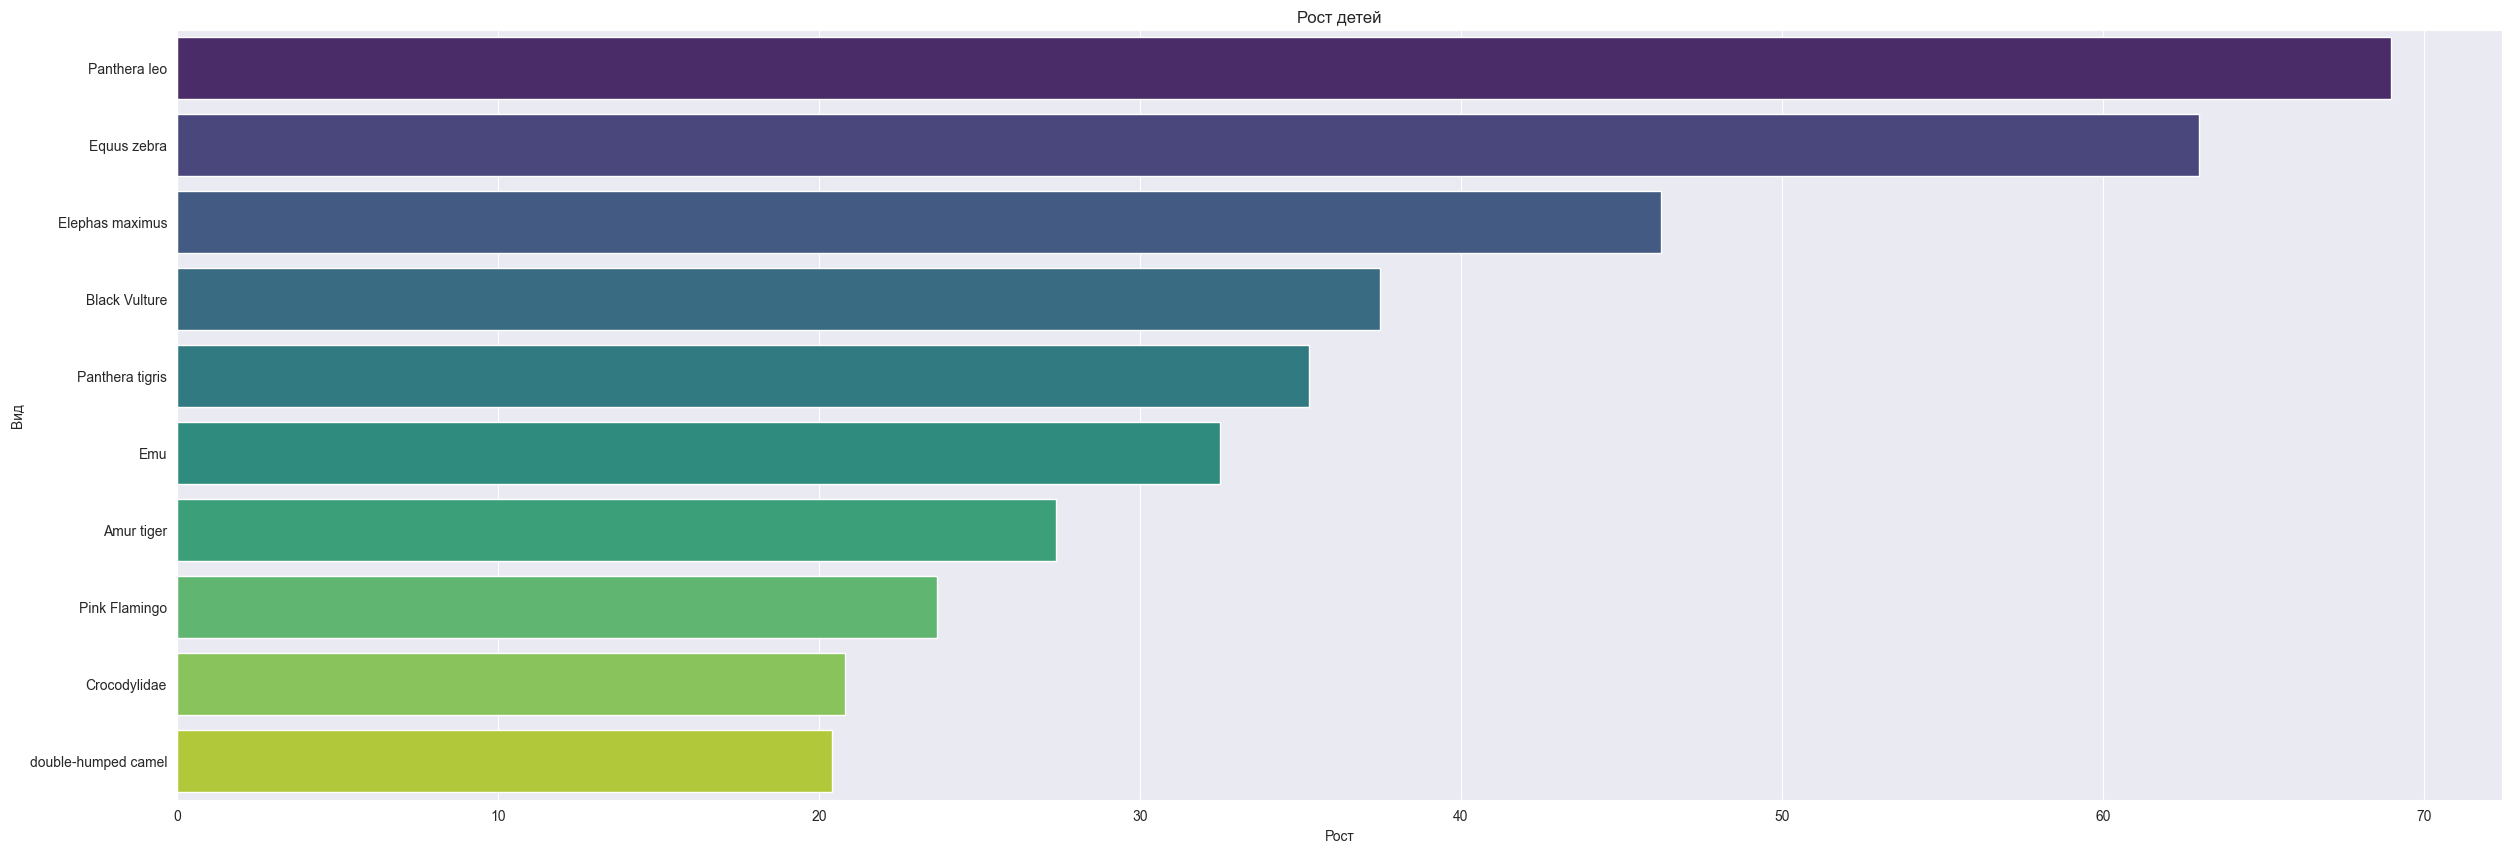

In [33]:
dt_gd_child = dt_gd[dt_gd['Зрелость'] == False]

dt_gd_child_mean = dt_gd_child.groupby('Вид')['Рост'].mean().reset_index()

mean_height_by_species_sorted = dt_gd_child_mean.sort_values(by='Рост', ascending=False)[:10]

plt.figure(figsize=(30, 10))
sns.barplot(x='Рост', y='Вид', hue='Вид', data=mean_height_by_species_sorted, palette='viridis', legend=False)
plt.xlabel('Рост')
plt.ylabel('Вид')
plt.title('Рост детей')
plt.show()

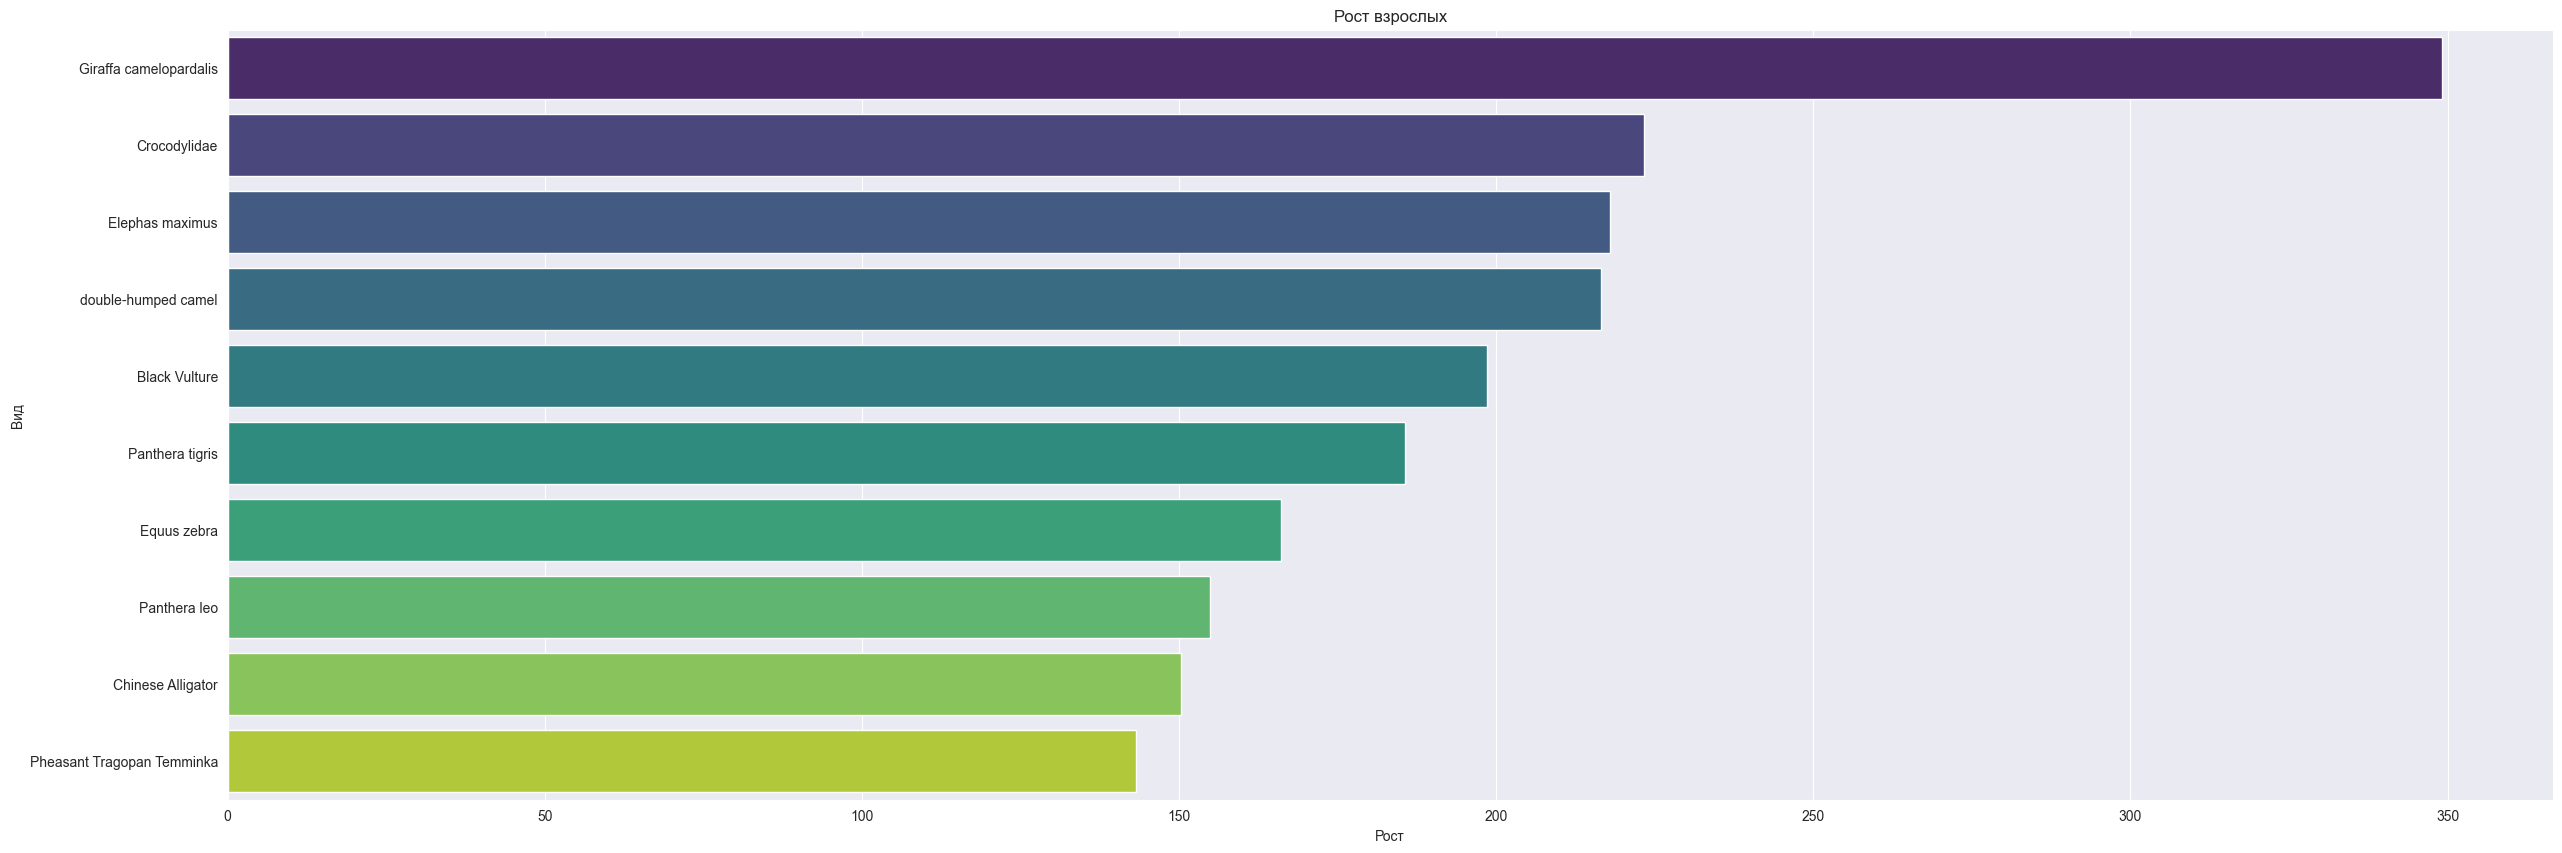

In [34]:
dt_gd_adult = dt_gd[dt_gd['Зрелость'] == True]

dt_gd_adult_mean = dt_gd_adult.groupby('Вид')['Рост'].mean().reset_index()

mean_height_by_species_sorted = dt_gd_adult_mean.sort_values(by='Рост', ascending = False)[:10]

plt.figure(figsize=(30, 10))
sns.barplot(x='Рост', y='Вид', hue='Вид', data=mean_height_by_species_sorted, palette='viridis', legend=False)
plt.xlabel('Рост')
plt.ylabel('Вид')
plt.title('Рост взрослых')
plt.show()

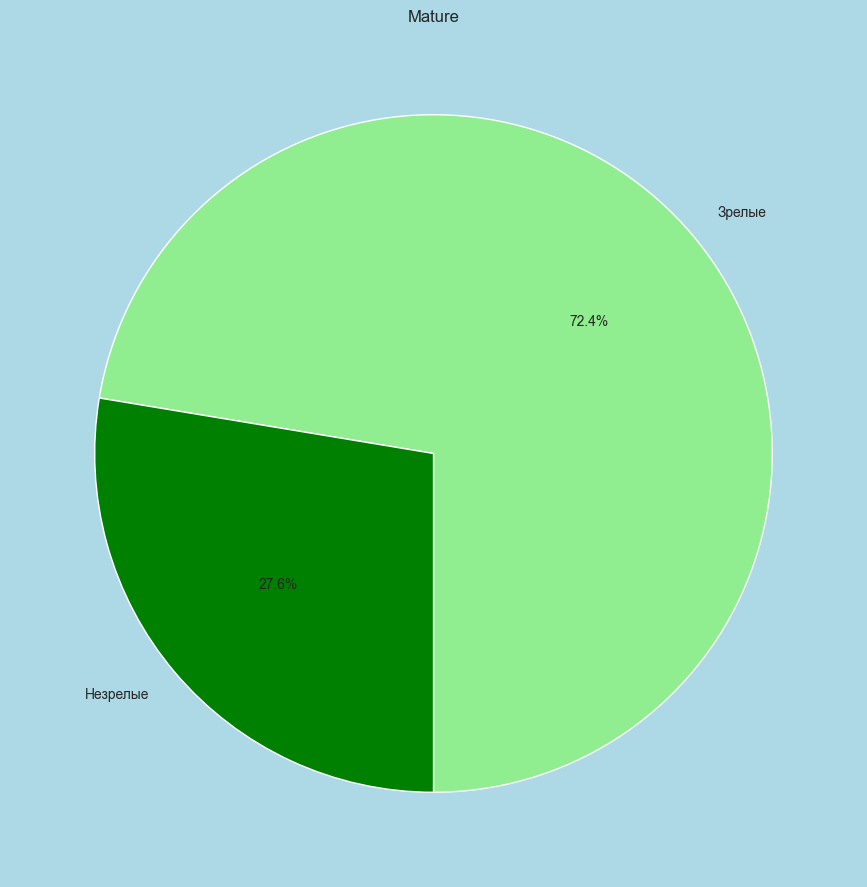

In [20]:
mature_counts = dt_gd['Зрелость'].value_counts()

label_mapping = {1: 'Зрелые', 0: 'Незрелые'}
mature_counts.index = mature_counts.index.map(label_mapping)
plt.figure(figsize=(11, 11), facecolor='lightBlue')
plt.pie(mature_counts, labels=mature_counts.index, autopct='%1.01f%%', startangle=270, colors=['LightGreen', 'green'])
plt.title('Mature')
plt.show()

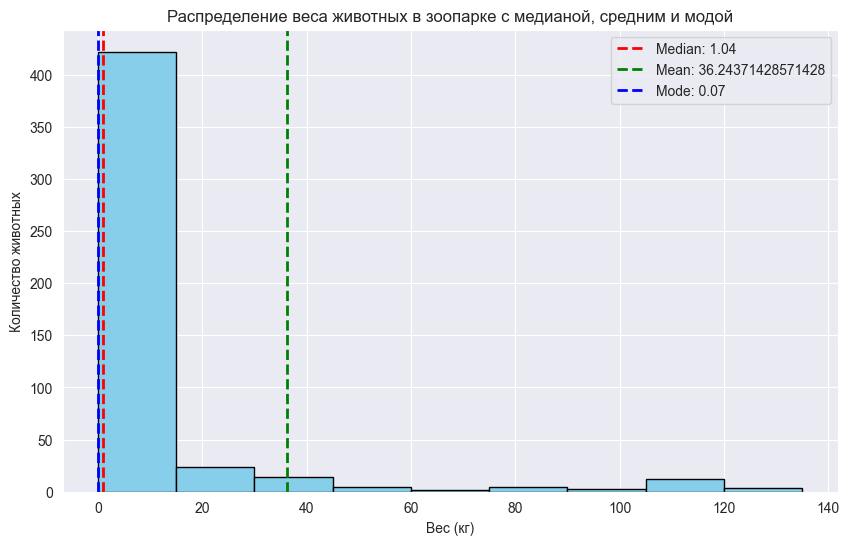

In [35]:

weights = dt_gd['Вес']


plt.figure(figsize=(10, 6))
plt.hist(weights, bins=[0, 15, 30, 45, 60, 75, 90, 105, 120, 135], color='skyblue', edgecolor='black')  


median_weight = np.median(weights)
plt.axvline(median_weight, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_weight}')


mean_weight = np.mean(weights)
plt.axvline(mean_weight, color='green', linestyle='dashed', linewidth=2, label=f'Mean: {mean_weight}')


mode_result = stats.mode(weights)
mode_weight = np.atleast_1d(mode_result.mode)[0] if np.atleast_1d(mode_result.mode).size > 0 else None

if mode_weight is not None:
    plt.axvline(mode_weight, color='blue', linestyle='dashed', linewidth=2, label=f'Mode: {mode_weight}')

plt.legend()

plt.title('Распределение веса животных в зоопарке с медианой, средним и модой')
plt.xlabel('Вес (кг)')
plt.ylabel('Количество животных')
plt.show()

In [22]:
dt_gd.describe()

,Зрелость,Вес,Рост
count,525.000000,525.000000,525.000000
mean,0.723810,36.243714,55.738952
std,0.447539,171.524618,63.745100
min,0.000000,0.020000,1.100000
25%,0.000000,0.470000,14.970000
50%,1.000000,1.040000,36.150000
75%,1.000000,5.650000,69.580000
max,1.000000,2793.510000,490.760000


## Вывод

График показывет, что хотя средний вес животных в зоопарке составляет около 36.24 кг, типичный вес, представленный медианным значением в 1.04 кг, значительно меньше. Это может указывать на то, что в зоопарке присутствует небольшое количество крупных животных, чей вес значительно выше среднего. Оптимизация плана питания, учитывая типичный вес животных, может помочь сбалансировать рационы и уменьшить излишнюю потребность в корме, что в свою очередь снизит расходы и поможет поддерживать здоровье животных в зоопарке.

Исходя из сравнения данных о росте детенышей и взрослых особей жирафов, становится очевидным, что для детей необходимо предоставлять более просторные условия содержания. 

Оба параметра "Вес" и "Рост" имеют правую асимметрию, что может быть вызвано наличием выбросов или экстремальных значений в данных

### БД

In [23]:
s_species = dt_gd['Вид'].unique()

In [24]:
random_bools = np.random.choice([True, False], size=len(s_species))

random_series = pd.Series(random_bools, name='Is_Species')

opposite_series = ~random_series

id_series = [i for i in range(0, len(s_species))]


In [25]:
 df_specie_insert = pd.DataFrame({ 'Id': id_series,'name': s_species, 'warm_aviary': random_series,  'is_predator': opposite_series,})

In [26]:
print(df_specie_insert)

    Id                     name  warm_aviary  is_predator
0    0        Chinese Alligator        False         True
1    1        Venezuelan Amazon        False         True
2    2      Yellow-faced Amazon        False         True
3    3        Blue-faced Amazon         True        False
4    4  White-tailed wildebeest         True        False
..  ..                      ...          ...          ...
70  70                  Gorilla        False         True
71  71                   Aquila         True        False
72  72             Macropodidae         True        False
73  73              Equus zebra         True        False
74  74   Giraffa camelopardalis        False         True

[75 rows x 4 columns]


In [27]:
with open('C:/Users/tzeen/Documents/DataFiles/Create_zoo_script.txt', 'r', encoding='utf-8') as file:
    sql_create_script = file.read()

In [28]:
connection = psql.connect(
    dbname="zoo_database",
    user="postgres",
    password="1345",
    host="localhost",
)

cursor = connection.cursor()

cursor.execute(sql_create_script)

connection.commit()

In [29]:
for index, row in df_specie_insert.iterrows():
  sql = "INSERT INTO zoo.specie(specie_id ,name, is_predator, warm_aviary) VALUES (%s ,%s, %s, %s)"
  cursor.execute(sql, (row['Id'], row['name'], row['is_predator'], row['warm_aviary']))
connection.commit()

In [30]:
cursor.close()
connection.close()